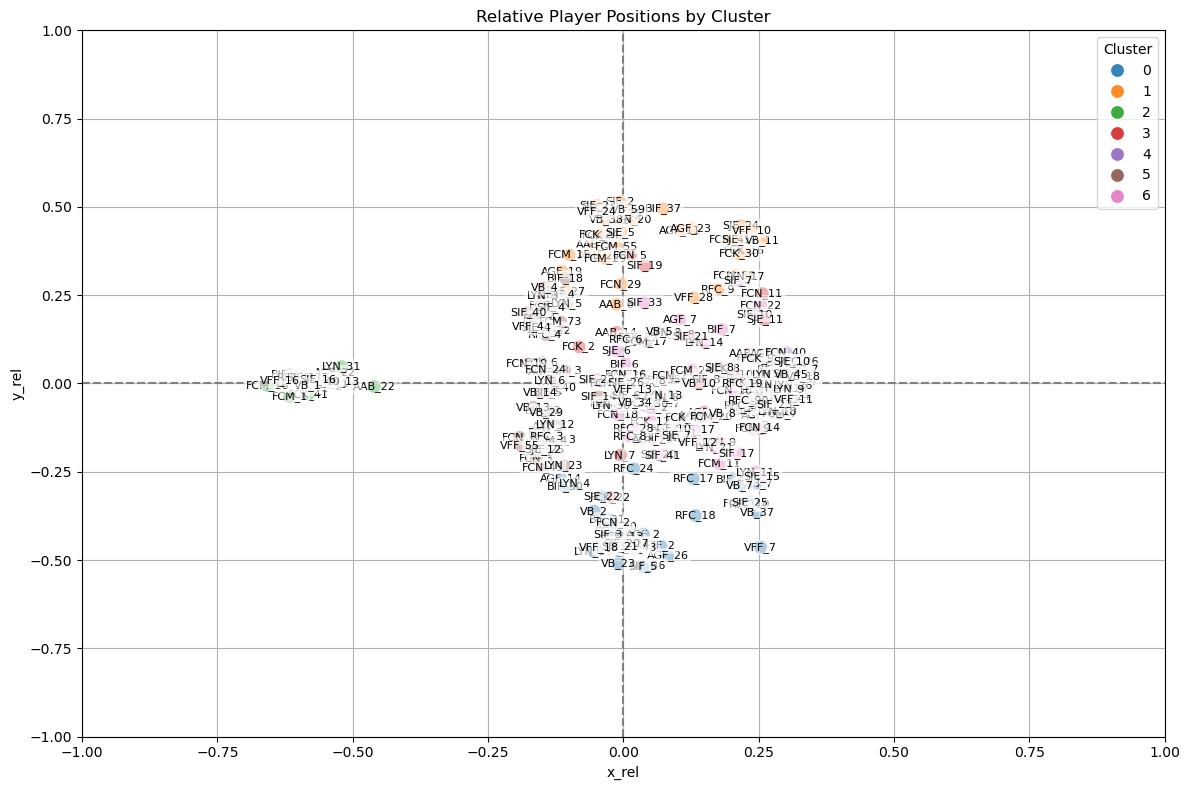

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# === Load dataset ===
df = pd.read_hdf("/Users/denizadiguzel/cluster_data_all_vxy_detailed.h5", key="df")

# === Step 1: Extract team and jersey number from player_id ===
df["team_extracted"] = df["player_id"].str.extract(r"player_([A-Z]+)_")[0]
df["number_extracted"] = df["player_id"].str.extract(r"player_[A-Z]+_([0-9]+)")[0]
df["label"] = df["team_extracted"] + "_" + df["number_extracted"]

# === Step 2: Compute team mean per match and subtract ===
team_means = df.groupby(["match_id", "team_extracted"])[["x", "y"]].mean().reset_index()
team_means = team_means.rename(columns={"x": "x_team_avg", "y": "y_team_avg"})

# Merge back into original df
df = df.merge(team_means, on=["match_id", "team_extracted"], how="left")

# === Step 3: Normalize x and y relative to team average per match ===
df["x_rel"] = df["x"] - df["x_team_avg"]
df["y_rel"] = df["y"] - df["y_team_avg"]

# === Step 4: Aggregate per player for clustering ===
player_stats = df.groupby("player_id")[["x_rel", "y_rel", "speed", "v_x", "v_y"]].mean()
player_stats["x_rel_std"] = df.groupby("player_id")["x_rel"].std().values
player_stats["y_rel_std"] = df.groupby("player_id")["y_rel"].std().values
player_stats["speed_std"] = df.groupby("player_id")["speed"].std().values
player_stats["v_x_std"] = df.groupby("player_id")["v_x"].std().values
player_stats["v_y_std"] = df.groupby("player_id")["v_y"].std().values

# === Add label back ===
player_stats["team_extracted"] = df.groupby("player_id")["team_extracted"].first().values
player_stats["number_extracted"] = df.groupby("player_id")["number_extracted"].first().values
player_stats["label"] = player_stats["team_extracted"] + "_" + player_stats["number_extracted"]

# === Choose features for clustering ===
#features = ["x_rel", "x_rel_std", "y_rel", "y_rel_std", "speed", "speed_std", "v_x", "v_x_std", "v_y", "v_y_std"]
features = ["x_rel", "x_rel_std", "y_rel", "y_rel_std", "speed", "speed_std"]
X = player_stats[features].values
X_scaled = StandardScaler().fit_transform(X)

# === KMeans Clustering ===
k = 7
kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
player_stats["cluster"] = kmeans.fit_predict(X_scaled)

# === Final Plot ===
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=player_stats,
    x="x_rel", y="y_rel", hue="cluster",
    palette="tab10", s=100, alpha=0.9, legend="full"
)

for _, row in player_stats.iterrows():
    plt.text(row["x_rel"], row["y_rel"], row["label"],
             fontsize=8, ha="center", va="center",
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.6))

plt.title("Relative Player Positions by Cluster")
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(True)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()



In [70]:
# === Print player labels and their cluster assignments ===
cluster_summary = player_stats[["label", "cluster"]].sort_values("cluster")

print("\n=== Cluster Assignments ===")
for cluster_id in sorted(cluster_summary["cluster"].unique()):
    players_in_cluster = cluster_summary[cluster_summary["cluster"] == cluster_id]["label"].tolist()
    print(f"\nCluster {cluster_id} ({len(players_in_cluster)} players):")
    print(", ".join(players_in_cluster))



=== Cluster Assignments ===

Cluster 0 (36 players):
VFF_7, AGF_14, SJE_20, AGF_2, BIF_41, LYN_19, AGF_26, LYN_2, SIF_5, BIF_2, SIF_36, LYN_24, BIF_31, BIF_30, RFC_27, RFC_24, RFC_18, RFC_17, RFC_10, SIF_3, SJE_22, SJE_21, VB_23, FCM_13, VFF_18, VB_7, AAB_20, VB_37, FCN_2, VB_2, FCM_43, LYN_4, AAB_7, SJE_25, FCK_11, FCK_13

Cluster 1 (35 players):
FCK_15, BIF_24, FCK_24, FCM_58, FCM_15, FCM_29, FCM_41, FCK_16, LYN_20, LYN_17, FCM_55, BIF_37, FCN_29, FCN_25, RFC_44, FCK_30, VB_11, VB_59, SJE_5, AAB_5, AAB_6, VFF_10, SJE_24, SJE_23, AGF_11, AAB_24, AGF_19, AGF_23, AGF_27, SIF_2, RFC_9, VFF_24, VFF_28, SJE_17, VB_38

Cluster 2 (21 players):
FCM_16, VFF_16, FCM_1, LYN_32, LYN_40, SJE_16, SIF_1, FCK_41, LYN_31, RFC_1, VB_1, FCN_13, AAB_1, FCK_1, AGF_1, FCK_21, AGF_22, BIF_1, AAB_22, BIF_16, BIF_13

Cluster 3 (20 players):
FCN_8, FCM_20, RFC_19, SJE_11, FCK_10, FCM_6, AGF_8, SIF_19, SIF_21, FCN_11, FCK_2, FCK_22, LYN_7, AAB_14, AAB_8, VB_10, FCN_5, AGF_40, AAB_11, LYN_15

Cluster 4 (34 play

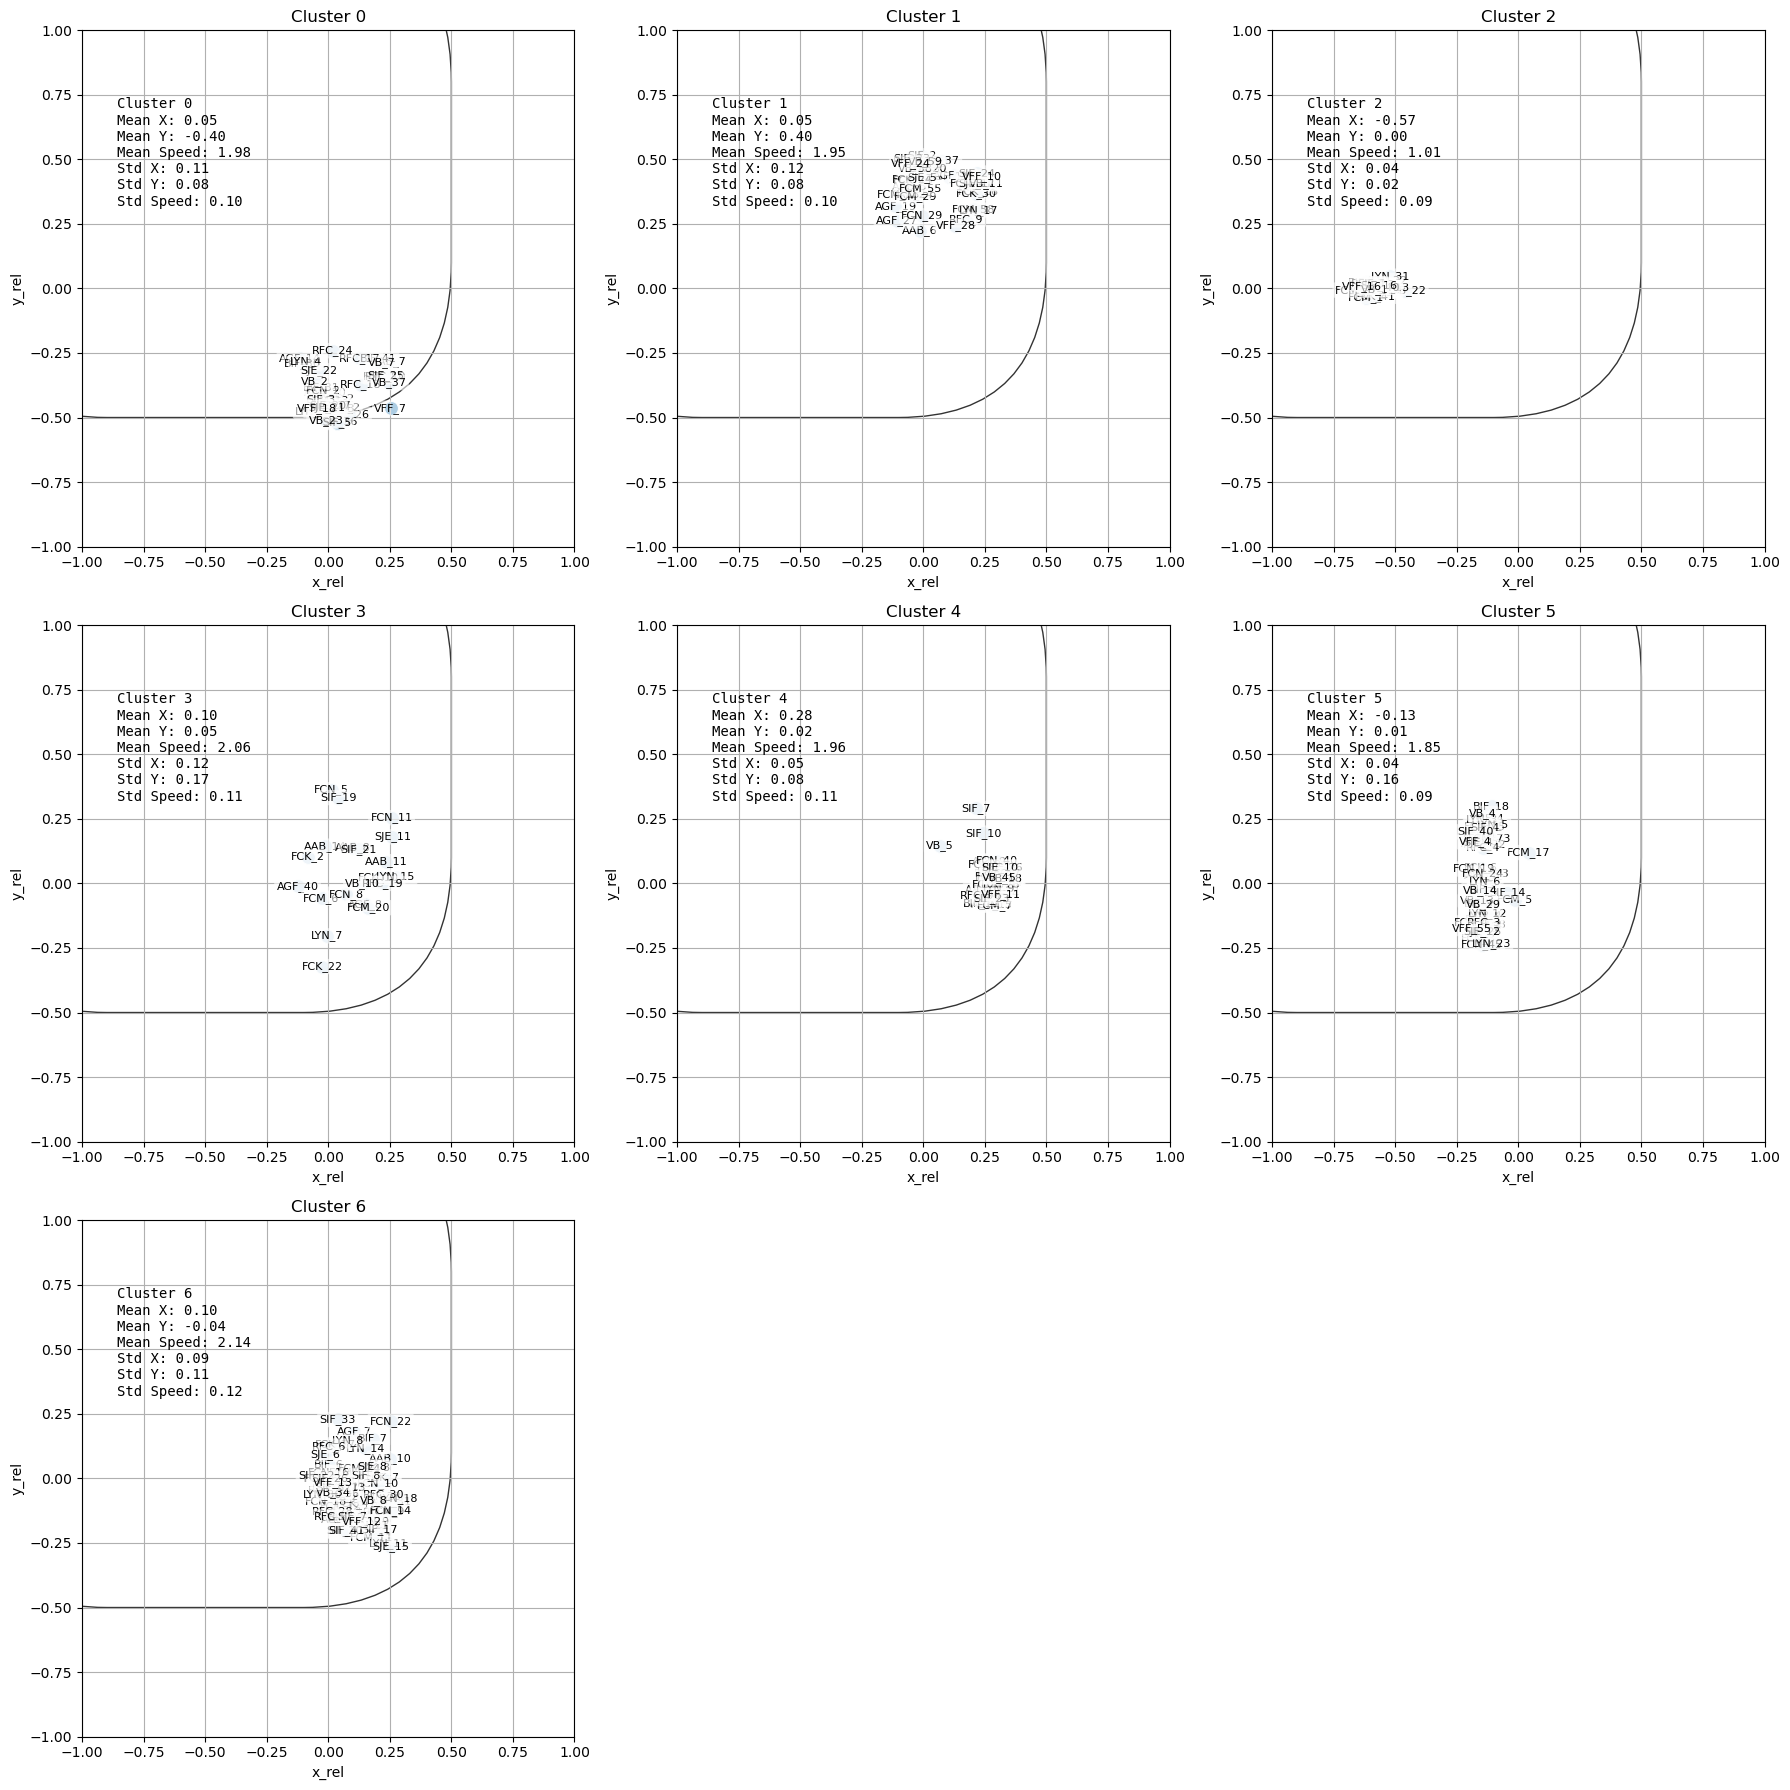

In [71]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
import numpy as np

# === Setup grid layout ===
cluster_ids = sorted(player_stats["cluster"].unique())
num_clusters = len(cluster_ids)
cols = 3
rows = int(np.ceil(num_clusters / cols))

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows))
axes = axes.flatten()

for idx, cluster_id in enumerate(cluster_ids):
    ax = axes[idx]
    cluster_df = player_stats[player_stats["cluster"] == cluster_id]

    # Summary stats (on relative positions)
    x_mean = cluster_df["x_rel"].mean()
    y_mean = cluster_df["y_rel"].mean()
    speed_mean = cluster_df["speed"].mean()
    x_std = cluster_df["x_rel"].std()
    y_std = cluster_df["y_rel"].std()
    speed_std = cluster_df["speed"].std()

    summary_text = (
        f"Cluster {cluster_id}\n"
        f"Mean X: {x_mean:.2f}\n"
        f"Mean Y: {y_mean:.2f}\n"
        f"Mean Speed: {speed_mean:.2f}\n"
        f"Std X: {x_std:.2f}\n"
        f"Std Y: {y_std:.2f}\n"
        f"Std Speed: {speed_std:.2f}"
    )

    # Scatter plot
    sns.scatterplot(data=cluster_df, x="x_rel", y="y_rel", s=100, alpha=0.9, ax=ax, legend=False)

    # Labels
    for _, row in cluster_df.iterrows():
        ax.text(row["x_rel"], row["y_rel"], row["label"],
                fontsize=8, ha="center", va="center",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.6))

    # Stats box
    ax.add_patch(FancyBboxPatch(
        (0.05, 0.55), 0.4, 0.35,
        transform=ax.transAxes,
        boxstyle="round,pad=0.3",
        facecolor="white", edgecolor="black", alpha=0.8
    ))
    ax.text(0.07, 0.87, summary_text,
            transform=ax.transAxes,
            fontsize=10, family="monospace", verticalalignment="top")

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(f"Cluster {cluster_id}")
    ax.grid(True)

# Hide unused axes
for j in range(len(cluster_ids), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


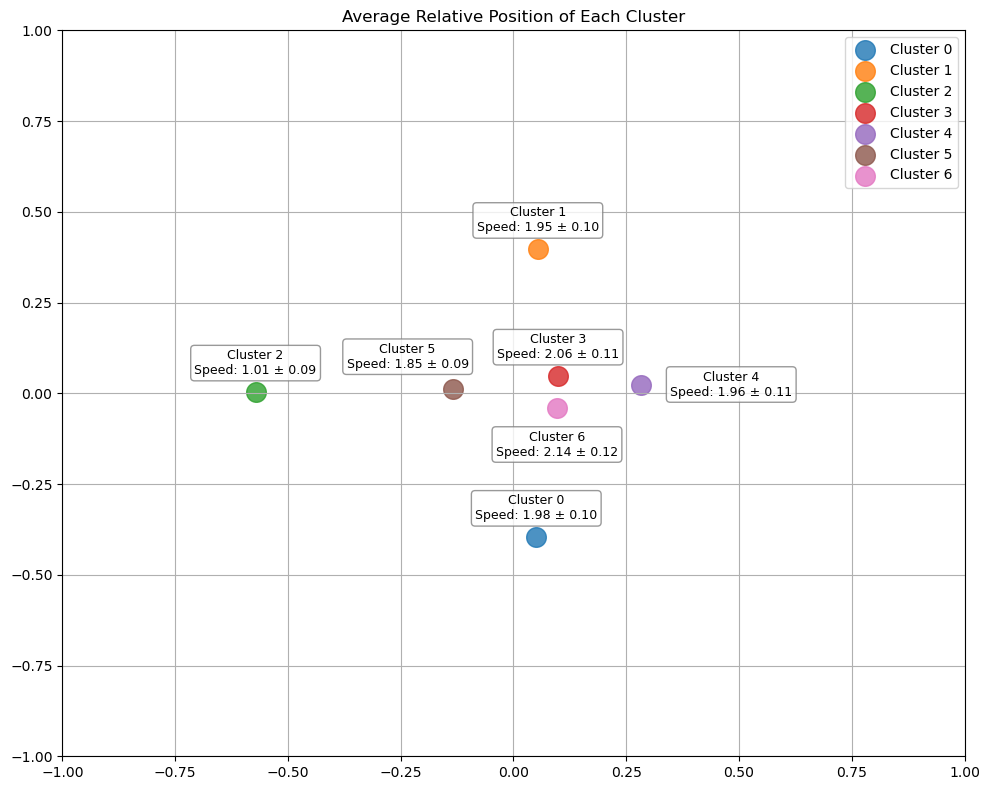

In [72]:
# === Plot average relative position of each cluster with speed ± std ===
plt.figure(figsize=(10, 8))

for cluster_id in sorted(player_stats["cluster"].unique()):
    cluster_df = player_stats[player_stats["cluster"] == cluster_id]
    x_mean = cluster_df["x_rel"].mean()
    y_mean = cluster_df["y_rel"].mean()
    speed_mean = cluster_df["speed"].mean()
    speed_std = cluster_df["speed"].std()

    # Plot cluster center
    plt.scatter(x_mean, y_mean, s=200, alpha=0.8, label=f"Cluster {cluster_id}")

    # Default offsets and alignment
    x_offset, y_offset = 0.0, 0.04
    ha, va = "center", "bottom"

    # Custom placements
    if cluster_id == 4:
        x_offset = 0.2
        y_offset = 0.0
        ha, va = "center", "center"
    elif cluster_id == 5:
        x_offset = -0.1
        y_offset = 0.09
        ha, va = "center", "center"
    elif cluster_id == 6:
        y_offset = -0.1
        ha, va = "center", "center"

    # Annotate
    plt.text(
        x_mean + x_offset, y_mean + y_offset,
        f"Cluster {cluster_id}\nSpeed: {speed_mean:.2f} ± {speed_std:.2f}",
        ha=ha, va=va, fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )

plt.title("Average Relative Position of Each Cluster")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


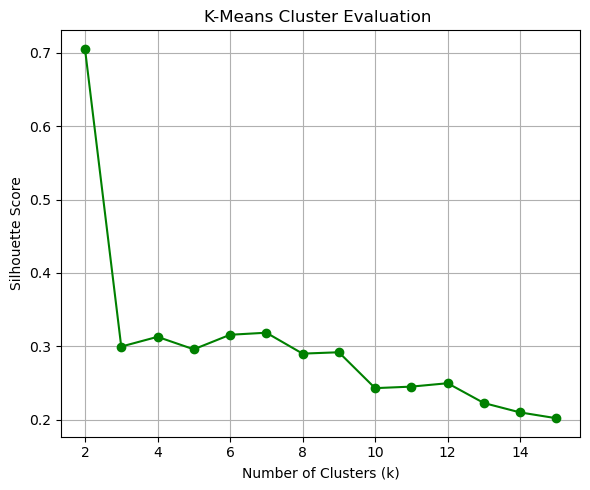

In [73]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Try different k values
k_values = range(2, 16)
inertias = []
silhouettes = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Plot Elbow and Silhouette scores
fig, axes = plt.subplots(1, 1, figsize=(6, 5))

# # Elbow Method (Inertia)
# axes[0].plot(k_values, inertias, marker='o')
# axes[0].set_title("Elbow Method (Inertia)")
# axes[0].set_xlabel("Number of Clusters (k)")
# axes[0].set_ylabel("Inertia")
# axes[0].grid(True)

# Silhouette Score
axes.plot(k_values, silhouettes, marker='o', color='green')
axes.set_title("K-Means Cluster Evaluation ")
axes.set_xlabel("Number of Clusters (k)")
axes.set_ylabel("Silhouette Score")
axes.grid(True)

#plt.suptitle("K-Means Cluster Evaluation ")
plt.tight_layout()
plt.show()


In [75]:
# === Save player names and their cluster assignments ===
player_clusters = player_stats[["label", "cluster"]].sort_values("cluster")

# Save to CSV
output_path = "/Users/denizadiguzel/player_clusters.csv"
player_clusters.to_csv(output_path, index=False)

print(f"Saved player-cluster assignments to:\n{output_path}")


Saved player-cluster assignments to:
/Users/denizadiguzel/player_clusters.csv
